In [1]:
import gzip

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt

# Preprocessing

## Meta data

In [2]:
def read_geo_series_matrix(file_path):
    cols = {}
    with gzip.open(file_path, 'rt') as f:
        for line in f:
            if line.startswith("!Sample_title"):
                sampleId = [i.strip('"') for i in line.split()[1:]]
                cols["sampleId"] = sampleId
            elif line.startswith("!Sample_characteristics_ch1"):
                _ = line[28:].strip().strip('"').split('"\t"')
                category = _[0].split(": ")[0].replace(" ", "_")
                values = [i.split(": ")[1] for i in _]
                cols.update({category: values})
    
    return pd.DataFrame(cols)

In [3]:
meta = read_geo_series_matrix("../rawData/GSE49711_series_matrix.txt.gz")
meta.index = meta.sampleId
meta.shape

(498, 11)

In [4]:
meta = meta.loc[meta.death_from_disease.isin(["0", "1"])]
meta.shape

(498, 11)

In [5]:
pd.crosstab(meta.inss_stage, meta.death_from_disease)

death_from_disease,0,1
inss_stage,,
1,120,1
2,74,4
3,49,14
4,101,82
4S,49,4


In [6]:
pd.crosstab(meta.high_risk, meta.death_from_disease)

death_from_disease,0,1
high_risk,,
0,309,13
1,84,92


In [7]:
meta.Sex.replace({"M":1, "F":0}, inplace=True)
meta.replace({"N/A":np.nan}, inplace=True)

In [8]:
stage_dummy = pd.get_dummies(meta.inss_stage, prefix='inss_stage')
meta = pd.concat([meta, stage_dummy], axis=1)

In [9]:
meta = meta[["Sex", "age_at_diagnosis", "mycn_status", "high_risk", 
               "inss_stage_1", "inss_stage_2", "inss_stage_3", "inss_stage_4", "inss_stage_4S",
               "death_from_disease"
              ]]

In [10]:
meta.dropna(inplace=True)

In [11]:
meta = meta.astype("double")

In [12]:
meta.head()

,Sex,age_at_diagnosis,mycn_status,high_risk,inss_stage_1,inss_stage_2,inss_stage_3,inss_stage_4,inss_stage_4S,death_from_disease
sampleId,,,,,,,,,,
SEQC_NB001,1.0,987.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
SEQC_NB002,1.0,1808.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
SEQC_NB003,0.0,625.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
SEQC_NB004,0.0,335.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
SEQC_NB005,0.0,536.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


## Gene level

In [13]:
rna = pd.read_table("../rawData/GSE49711_SEQC_NB_TAV_G_log2.final.txt.gz")
rna = rna[~ rna.Gene.str.contains("[a-z]")]
rna.drop(["Gene_set","NCBI_gene_ID","RefSeq_transcript_ID","Chromosome","Strand","Start","End"], axis=1, inplace=True)
X = rna.iloc[:,1:].transpose()
X.columns = rna.Gene

In [14]:
X = X.loc[meta.index] # keep only samples with valid Ys

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, meta.death_from_disease.astype("int"), test_size=0.4, random_state=1234)

# QC

<Axes: >

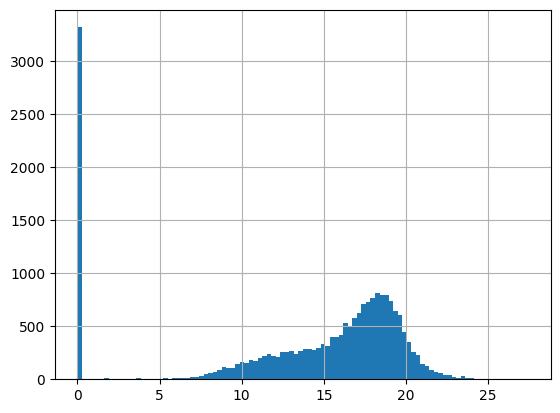

In [16]:
X_train.median().hist(bins=100)

In [17]:
X_train = X_train.loc[:, X_train.median() > 5]

In [18]:
X_train.shape

(295, 17711)

In [19]:
X_train

Gene,A1BGAS,A2BP1,A2LD1,A2M,A2ML1,A2MP1,A4GALT,A4GNT,AAAS,AACS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
sampleId,,,,,,,,,,,,,,,,,,,,,
SEQC_NB146,16.5024,20.0564,15.0841,21.6655,9.8009,12.8555,15.8551,9.1470,19.7981,18.1232,...,18.5765,18.2535,15.3898,16.6328,18.4678,7.8161,19.5133,19.6439,19.4788,18.8513
SEQC_NB169,16.3556,16.8176,14.1696,20.3013,10.3583,11.4638,16.4427,10.5210,19.6067,18.3675,...,18.9689,18.7735,13.9497,16.1754,17.4339,15.0595,19.0750,20.2097,18.8517,18.7465
SEQC_NB178,16.5744,19.9334,15.2004,19.5386,11.6829,10.2534,13.8344,9.3267,19.5844,18.3651,...,18.9971,18.8412,14.6071,16.1876,17.9747,8.0051,19.6285,19.5114,19.4049,18.6343
SEQC_NB148,15.9723,20.6821,13.6735,20.3745,11.7534,10.2431,14.7050,10.0318,20.0699,18.0863,...,18.5875,18.5007,14.7794,16.1984,18.6119,7.7073,19.5750,19.4555,19.1903,18.9590
SEQC_NB136,16.7822,15.0439,14.4207,21.5849,9.8255,10.0645,16.2768,10.6923,19.9487,18.6586,...,17.9663,18.3867,15.2904,16.8536,18.3172,7.8497,18.8057,19.6194,19.0896,17.9436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEQC_NB207,17.3286,17.4852,15.2080,21.4776,11.1628,10.5469,15.1864,10.9370,20.0399,18.8091,...,17.2345,16.6182,15.3670,16.6561,18.6597,13.1425,20.0924,20.8257,19.8991,18.8717
SEQC_NB054,16.6492,19.5313,14.2535,21.6060,13.1517,12.1404,15.4274,11.4453,19.8313,18.5733,...,17.4503,17.9483,15.2092,17.0717,18.2799,10.3980,20.3791,19.9456,19.6730,18.9018
SEQC_NB298,17.9505,19.0510,15.8982,23.8811,7.8454,0.0000,14.8744,13.9422,19.8731,18.4631,...,17.8283,17.8293,15.1580,16.2733,18.7405,13.1793,19.4190,19.8722,19.3323,18.7078


In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)

In [21]:
X_test_scaled = scaler.transform(X_test.loc[:, X_train.columns])
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_train.columns)

In [22]:
meta_train = meta.loc[X_train.index]
age_scaler = StandardScaler()
age_at_diagnosis = age_scaler.fit_transform(np.array(meta_train.age_at_diagnosis).reshape(-1, 1))
meta_train.age_at_diagnosis = age_at_diagnosis
meta_train.drop("death_from_disease", axis = 1, inplace=True)

In [23]:
X_train_scaled = pd.concat([X_train_scaled, meta_train], axis=1)

In [24]:
meta_test = meta.loc[X_test.index]
age_at_diagnosis = age_scaler.transform(np.array(meta_test.age_at_diagnosis).reshape(-1, 1))
meta_test.age_at_diagnosis = age_at_diagnosis
meta_test.drop("death_from_disease", axis = 1, inplace=True)

In [25]:
X_test_scaled = pd.concat([X_test_scaled, meta_test], axis=1)

# L1 Logistic regression

In [26]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report

In [27]:
model = LogisticRegressionCV(penalty='l1', solver='liblinear', cv = 5, random_state=1234, Cs= 20, class_weight="balanced")
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)

In [28]:
accuracy

0.8181818181818182

In [29]:
pd.crosstab(y_pred, y_test)

death_from_disease,0,1
row_0,,
0,136,14
1,22,26


In [30]:
pd.crosstab(meta.loc[y_test.index].high_risk, meta.loc[y_test.index].death_from_disease)

death_from_disease,0.0,1.0
high_risk,,
0.0,122,4
1.0,36,36


In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88       158
           1       0.54      0.65      0.59        40

    accuracy                           0.82       198
   macro avg       0.72      0.76      0.74       198
weighted avg       0.83      0.82      0.82       198



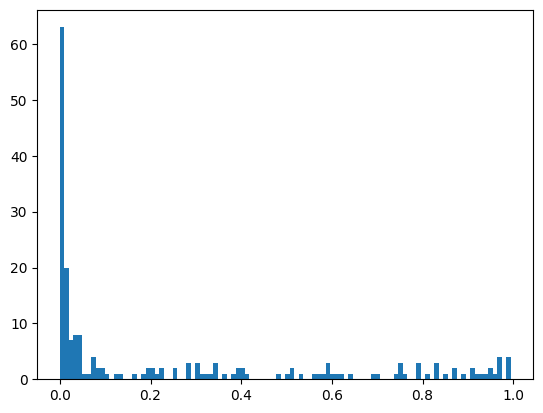

In [32]:
_ = plt.hist(model.predict_proba(X_test_scaled)[:,1], 100)

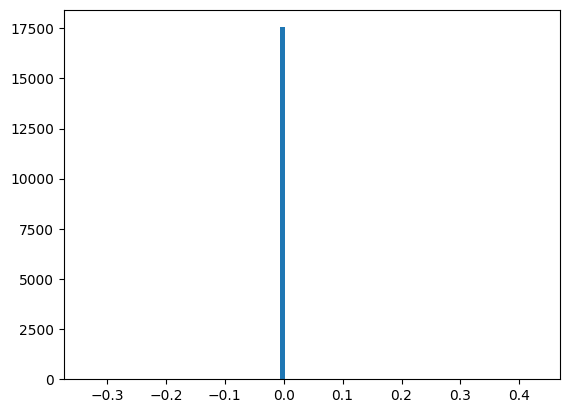

In [33]:
_ = plt.hist(model.coef_[0], 100)

In [34]:
sum(model.coef_[0] != 0)

180

In [35]:
indices = np.argsort(model.coef_[0])[::-1]

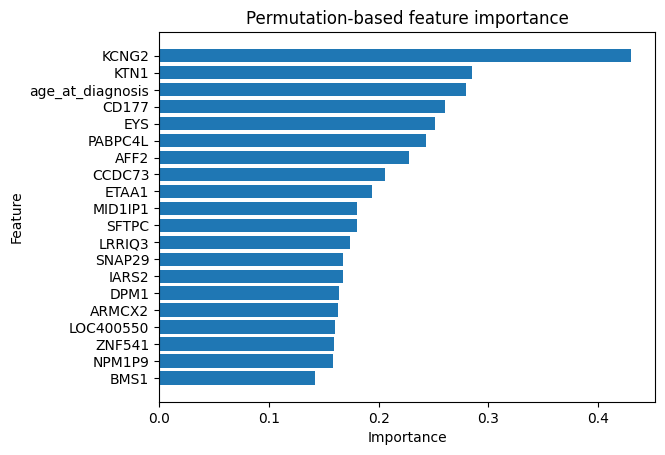

In [36]:
plt.barh(X_train_scaled.columns[indices][range(20)][::-1], model.coef_[0][indices][range(20)][::-1])
plt.title("Permutation-based feature importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

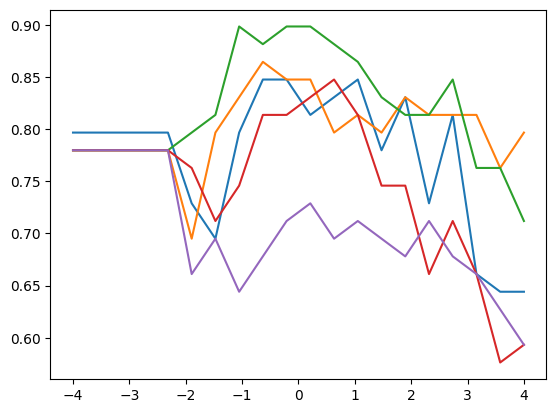

In [37]:
plt.plot(np.log10(model.Cs_), model.scores_[1].T)
plt.show()

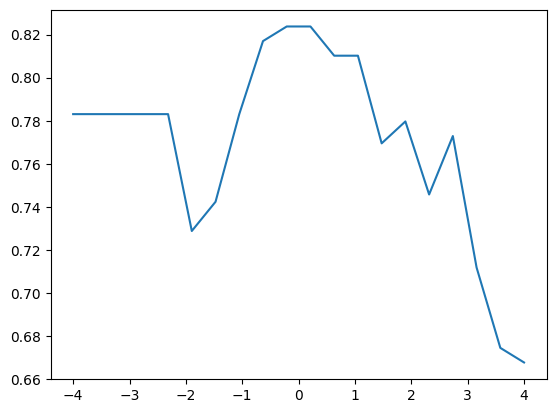

In [38]:
plt.plot(np.log10(model.Cs_), np.mean(model.scores_[1].T, axis = 1))
plt.show()

# Ranodm forest

In [39]:
from sklearn.ensemble import RandomForestClassifier


In [40]:
X_train = pd.concat([X_train, meta_train], axis=1)
X_test = pd.concat([X_test, meta_test], axis=1)

In [41]:
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=1234, class_weight="balanced")
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test.loc[:, X_train.columns])

In [42]:
accuracy = accuracy_score(y_test, y_pred)

In [43]:
accuracy

0.8232323232323232

In [44]:
pd.crosstab(y_pred, y_test)

death_from_disease,0,1
row_0,,
0,152,29
1,6,11


In [45]:
pd.crosstab(meta.loc[y_test.index].high_risk, meta.loc[y_test.index].death_from_disease)

death_from_disease,0.0,1.0
high_risk,,
0.0,122,4
1.0,36,36


In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.96      0.90       158
           1       0.65      0.28      0.39        40

    accuracy                           0.82       198
   macro avg       0.74      0.62      0.64       198
weighted avg       0.80      0.82      0.79       198



In [47]:
importances = rf_classifier.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

In [48]:
# Print the feature ranking
print("Feature ranking:")
for f in range(20):
    print("%d. %s: feature %d (%f)" % (f + 1, X_train.columns[indices[f]], indices[f], importances[indices[f]]))

Feature ranking:
1. NR2C2AP: feature 10693 (0.005323)
2. NPM1P9: feature 10660 (0.005153)
3. SLC25A5: feature 14325 (0.004376)
4. ZNF641: feature 17525 (0.004221)
5. POLE3: feature 11827 (0.004191)
6. high_risk: feature 17714 (0.004183)
7. ARHGEF10L: feature 802 (0.003875)
8. HNRNPC: feature 6024 (0.003784)
9. CNIH4: feature 2472 (0.003513)
10. PGM2L1: feature 11460 (0.003378)
11. ELK1: feature 3811 (0.003373)
12. TRNAU1AP: feature 16169 (0.003206)
13. age_at_diagnosis: feature 17712 (0.003038)
14. LOC100288145: feature 7838 (0.002968)
15. ZBTB4: feature 17083 (0.002837)
16. CLPP: feature 2426 (0.002761)
17. TOM1L2: feature 15970 (0.002730)
18. SLC1A5: feature 14260 (0.002614)
19. ALG3: feature 465 (0.002511)
20. NME2P1: feature 10578 (0.002479)


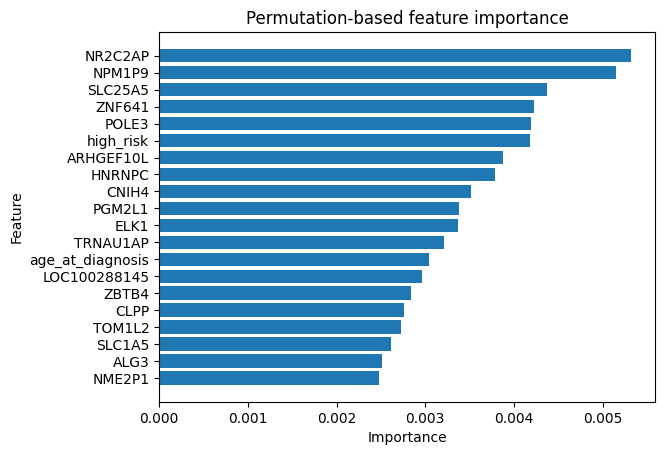

In [49]:
plt.barh(X_train.columns[indices][range(20)][::-1], importances[indices][range(20)][::-1])
plt.title("Permutation-based feature importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()